<a href="https://colab.research.google.com/github/1rd0/BekEnd_lab/blob/master/MLP_pytorch_dpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №5

**Многослойный перцептрон в pytorch**

---

**Впишите в эту ячейку ваши ФИО, группу и вариант**.

ФИО:Рабдел Дмитрий Александрович

Группа:221-371

---

## Работа с тензорами

**Совет по работе**

Создавайте отдельные ячейки для ваших экспериментов. Пробуйте создавать небольшие тензоры и экспериментировать с ними, чтобы понять, как работает та или иная функция и какие размерности данных вам требуются.

Когда дойдете до цикла обучения сначала пробуйте работать с одной эпохой и ограниченным набором пакетов данных, чтобы меньше времени ожидать до обнаружения ошибки.

Создайте тензор a из `list(range(9))`.

In [1]:
import torch
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

a = torch.tensor(list(range(9)))
print(a)
print(a.size())
print(a.storage_offset())
print(a.stride())

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
torch.Size([9])
0
(1,)



Каковы его размеры (`size`), сдвиг (`storage_offset`) и шаг (`stride`)?**

Ваш ответ:9,0,1


**Создайте** новый тензор b размерностью 3 на 3, используя метод `view` на тензоре a.

In [2]:
b = a.view(3, 3)
print(b)

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])





**Что делает view?**

Ваш ответ:представления данных в новой форме,

Создайте тензор c, который содержит только последнюю колонку тензора b, используя срезы.

In [3]:
c = b[::, -1]
print(c)

tensor([2, 5, 8])


Измените последний элемент в тензоре c.

In [6]:
c[-1] = 4
print(a[-1])

tensor(4)


**Изменился ли при этом тензор a?**

Ваш ответ:Yep


## Чтение данных и dataset

Из встроенных датасетов torchvision загрузите тестовую и обучающую выборки из MNIST, указав преобразование для изображений используя ToTensor().

In [7]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_set = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_set = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 116652014.67it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44372049.02it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28237694.39it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13350055.20it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Датасеты позволяют получить общее количество объектов с помощью функции `len`, также - объект с классом по индексу. В атрибуте `classes` хранятся ярлыки классов.

In [8]:
train_samples_len = len(train_set)
test_samples_len = len(test_set)
image_shape = train_set.data.shape
classes_len = len(train_set.classes)
classes_labels = train_set.classes
print(train_samples_len,test_samples_len,image_shape,classes_len,classes_labels)

60000 10000 torch.Size([60000, 28, 28]) 10 ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## Создание dataloader

> Indented block



Данные при обучении модели редко передаются по одному образцу или все разом, обычно образцы объединяются в пакеты (batches) и уже они передаются на вход модели.

Размер пакета (batch size) часто выбирается как $2^n$ (16, 32, 64, 128) и часто это зависит от доступной памяти.

Загрузчики данных будут использоваться при обучении и тестировании модели и когда все пакеты были перебраны в датасете, это считается одной эпохой обучения. Чтобы между эпохами модель на обучалась на одинаковых пакетах их перемешивают (shuffle).

In [10]:
from torch.utils.data import DataLoader

In [11]:
train_loader = DataLoader(train_set, 32, shuffle=True)
test_loader = DataLoader(test_set, 32, shuffle=False)




**Что означает число 32 в примере для train_loader?**

Ваш ответ:сколько образцов данных будет использоваться одновременно


**Какая размерность будет у одного пакета данных?**

Ваш ответ:32, 28, 28

In [12]:
for img, label in train_loader:

  print(label.shape)
  break


torch.Size([32])


## Создание модели

Ваша задача при инициализации MLP, создать несколько линейных слоев и функцию активации (например ReLU), которые будут использоваться при прямом проходе в модели. Перед входным слоем не забудьте использовать для изображений `.flatten()`. Чтобы вы могли использовать пакеты данных, вам надо подумать какую часть тензора сделать "плоской".

- Линейный слой `nn.Linear`
- Функция активации `nn.ReLU`

In [13]:
import torch.nn as nn

In [49]:
class MLP(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_Input= nn.Linear(28 * 28, 270)
    self.layer_Hidden_1 = nn.Linear(270, 270)
    self.layer_hidden_2 = nn.Linear(270, 124)
    self.layer_hidden_3 = nn.Linear(124, 50)
    self.layer_output = nn.Linear(50, 10)
    self.relu = nn.ReLU()

  def forward(self, x):

    x = x.view(-1, 28 * 28)
    x = self.relu(self.layer_Input(x))
    x = self.relu(self.layer_Hidden_1(x))
    x = self.relu(self.layer_hidden_2(x))
    x = self.relu(self.layer_hidden_3(x))
    x = self.layer_output(x)

    return x

In [50]:
model = MLP()

In [16]:
for param in model.parameters():
  print(param.shape)

torch.Size([270, 784])
torch.Size([270])
torch.Size([270, 270])
torch.Size([270])
torch.Size([124, 270])
torch.Size([124])
torch.Size([50, 124])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [17]:
total_parametrs= sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_parametrs)

325484


**Сколько параметров в вашей модели?**

Ваш ответ:325484

## Функция потерь и оптимизатор

В задаче классификации чаще всего используется функция потерь на основе перекрестной энтропии.

В качестве оптимизатора для параметров модели можно выбрать стохастический градиентный спуск или Adam.

In [51]:
loss_fn = nn.CrossEntropyLoss()

In [52]:
from torch.optim import SGD

LR = 0.025 # выберите значение в диапазоне от 0.1 до 0.0001

optimizer = SGD(model.parameters(), lr=LR)

## Цикл обучения

In [74]:
import torch.nn.functional as F
регулиризации
n_epochs = 16

best_acc = 0

for epoch in range(n_epochs):
  train_loss = 0
  train_correct = 0
  test_loss = 0
  test_correct = 0
  print(f"Эпоха №{epoch+1}")
  model.train() # переключение модели в режим обучения
  for imgs, labels in train_loader:


    optimizer.zero_grad()
# Обнуляем гардиент
    output = model(imgs)
#  передаем в функцию потерь предикшн и лейбл
    loss = loss_fn(output, labels)
#выставляет гардиенты
    loss.backward()

    optimizer.step()

    train_loss += loss.item()



    train_correct += sum(torch.argmax(output[i]).item() == labels[i].item() for i in range(len(output)))

    avg_train_loss = train_loss / len(train_loader)

  train_acc = train_correct / len(train_set)
  print(f"Потери на обучающей выборке {avg_train_loss:.5f}")
  print(f"Точность на обучающей выборке: {train_acc*100:.2f}%")

  model.eval() # переключение модели в режим оценивания
  for imgs, labels in test_loader:
    with torch.no_grad(): # работа в контексте отключенного вычисления градиентов
      # Для оценки модели:
      # 1. Получение вывода модели по пакету данных
      output_mark = model(imgs)
      # 2. Вычисление потерь на основе вывода модели и исходных значений
      loss = loss_fn(output_mark, labels)
      # 3. Вычисление метрики

      test_loss += loss.item()
      test_correct += sum(torch.argmax(output_mark[i]).item() == labels[i].item() for i in range(len(output_mark)))

  avg_test_loss = test_loss / len(test_loader)
  test_acc = test_correct / len(test_set)
  print(f"Потери на тестовой выборке {avg_test_loss:.5f}")
  print(f"Точность на тестовой выборке: {test_acc*100:.2f}%")

  if test_acc > best_acc:
    best_acc = test_acc
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            }, "best_model_params.pth")

NameError: name 'регулиризации' is not defined

**Почему для оценки модели стоит отключать вычисление градиентов `with torch.no_grad()`?**

Ваш ответ:не требуется обновление параметров модели на основе градиентов, поскольку оценка модели происходит после завершения процесса обучения.

## Загрузка модели и инференс

Ранее были оптимизированы параметры модели и словарь с параметрами для лучшей точности на проверочной выборке был сохранен в виде файла.

Модель обучается для ее использования с реальными данными, что и будет сделано в этой части задания.

Для этого вам потребуется нарисовать цифру в любом графическом редакторе (Paint, Gimp, Photoshop).

Требования к изображению происходят из тех данных, на которых обучалась модель. Поэтому изображение должно быть черно-белое, ширина и высота 28 px, черный фон, белая цифра. Формат может быть как png, так и jpg.

Для загрузки изображения в Google Colab в боковой панели откройте Files (1), и выберите вариант Upload to session storage (2).

Затем файл необходимо считать и подготовить перед тем, как передать в модель.

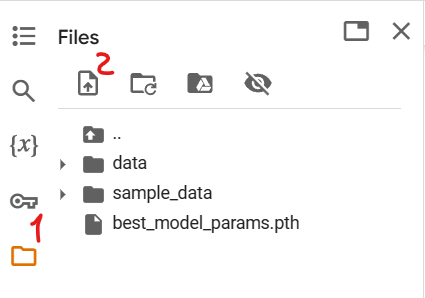

In [66]:
from PIL import Image
img = Image.open('Five_test.png')
print(f"Ширина и высота {img.size}, количество каналов {len(img.mode)}")
img

Ширина и высота (28, 28), количество каналов 4


**Соответствует ли изображение требованиям?**

Ваш ответ:нет

Если количество каналов у вас больше одного, то код далее поможет это исправить.

In [72]:
import torchvision.transforms as transforms
# Раскомментируйте, если у вас цветное изображение
transform_grayscale = transforms.Grayscale()
img = transform_grayscale(img)

# Используем те же преобразования как и при создании датасетов в начале задания
transform_to_tensor = transforms.ToTensor()
x = transform_to_tensor(img)

# Выведите размерности тензора x

#
print(x.size())
# Ваш код
#

torch.Size([1, 28, 28])


Но работа нашей модели строилась с учетом использования пакетов данных (batches), которые создавали экземпляры класса DataLoader, поэтому для использования одного изображения нам надо имитировать пакет из одного изображения. С этим поможет метод тензора `unsqueeze`, а чтобы не создавать отдельную переменную можно воспользоваться методом `unsqueeze_`.

In [73]:
#
x = x.unsqueeze(1)

Изображение подготовлено, теперь необходимо воссоздать модель и загрузить в нее параметры, которые дали наилучший результат при обучении.

In [69]:
best_model = MLP()
best_model_params = torch.load('best_model_params.pth') # Укажите путь до сохраненного файла
state_dict = best_model_params['model_state_dict']
best_model.load_state_dict(state_dict)
best_model.eval()

MLP(
  (layer_Input): Linear(in_features=784, out_features=270, bias=True)
  (layer_Hidden_1): Linear(in_features=270, out_features=270, bias=True)
  (layer_hidden_2): Linear(in_features=270, out_features=124, bias=True)
  (layer_hidden_3): Linear(in_features=124, out_features=50, bias=True)
  (layer_output): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

Осталось воспользоваться моделью. Передайте на вход модели подготовленный тензор. Из вывода модели получите индекс наибольшего значения (`argmax`) и по индексу получите результат из массива ярлыков классов (`test_set.classes`).

In [70]:
#
Predict = best_model(x)
index = torch.argmax(Predict)
class_preidct = test_set.classes[index]
print('Предсказанный класс: ', class_preidct)


Предсказанный класс:  8 - eight


**Правильно ли предсказала модель цифру?**

Ваш ответ:Нет

**Лучшая точность на тестовой выборке для вашей модели.**

Ваш ответ:

**Что такое пакет данных (batch)?**

Ваш ответ:Пакет данных представляет собой набор данных, которые передаются в модель одновременно для обработки в процессе обучения.

**В чем заключается смысл стохастического градиентного спуска?**

Ваш ответ: берет один случайный образец из данных, вычисляет, насколько хорошо модель справляется с этим образцом, и делает небольшой шаг в направлении улучшения модели. Затем он берет следующий случайный образец и делает то же самое. Этот процесс повторяется много раз, пока модель не достигнет желаемого качества.